# Basic CNN for pothole detection using Fastai

The packages we'll need. Note, the repo includes a `env.yml` file so you can recreate the environment I used to experiment in by running `conda env create -f env.yml` or you can just install fastai with `conda install -c pytorch -c fastai fastai` and it will install everything you need to run this notebook.

In [1]:
from pathlib import Path

from fastai.basic_data import DatasetType
from fastai.callbacks import SaveModelCallback
from fastai.metrics import accuracy
from fastai.train import ClassificationInterpretation
from fastai.vision.data import ImageList
from fastai.vision.learner import cnn_learner
from fastai.vision.models import xresnet101
from fastai.vision.transform import ResizeMethod, get_transforms
from fastai.vision import imagenet_stats

ModuleNotFoundError: No module named 'fastai'

In [2]:
from fastai.vision import models
dir(models)

ModuleNotFoundError: No module named 'fastai'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip 'drive/My Drive/all_data.zip' 

Archive:  drive/My Drive/all_data.zip
replace all_data/aAAwuvUBxwBSvhR.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls

all_data  models       sample_submission.csv  test_ids_only.csv
drive	  sample_data  test.csv		      train_ids_labels.csv


In [ ]:
!cd

AttributeError: ignored

The first part of this notebook is a walkthrough of a very simple solution using minimal code. Thereafter, we add some details and hints on how the basic version can be improved.

## Basic version

### Data

The first thing we want to do is create a fastai databunch. This object contains all the information on how we want the data to be retrieved and processed before it gets sent to the model and optimiser. In this challenge we are dealing with image. *Insert info on the images here*.

The things we want to specify in the databunch are:

- where are the images?
- which of them do we want to use for training and which for testing?
- how should the images be labelled?
- what transforms and other preprocessing should be applied to the images before it is passed to the model?
- how big should the batches be?

All of this is done in the cell below:

In [ ]:

path = Path("")
il = ImageList.from_csv(path, 'train_ids_labels.csv', folder='all_data', suffix='.JPG')
sd = il.split_by_rand_pct(0.15)
ll = sd.label_from_df()
ll = ll.transform(get_transforms(), size=224)
data = ll.databunch(bs=64).normalize(imagenet_stats)

This adds the test set to the databunch.

In [ ]:
!ls

all_data  models       sample_submission.csv  test_ids_only.csv
drive	  sample_data  test.csv		      train_ids_labels.csv


In [ ]:
test = (ImageList.from_csv(path, 'test_ids_only.csv', folder='all_data', suffix='.JPG'))
data.add_test(test)

The databunch looks like this:

In [ ]:
data

ImageDataBunch;

Train: LabelList (3423 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,1
Path: .;

Valid: LabelList (603 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,1,0
Path: .;

Test: LabelList (1650 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: .

Inspect the interim objects to get a better idea what happened at each of the steps, *e.g.* the image list:

In [ ]:
il

ImageList (4026 items)
Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800),Image (3, 600, 800)
Path: .

Now we can look at a batch of data:

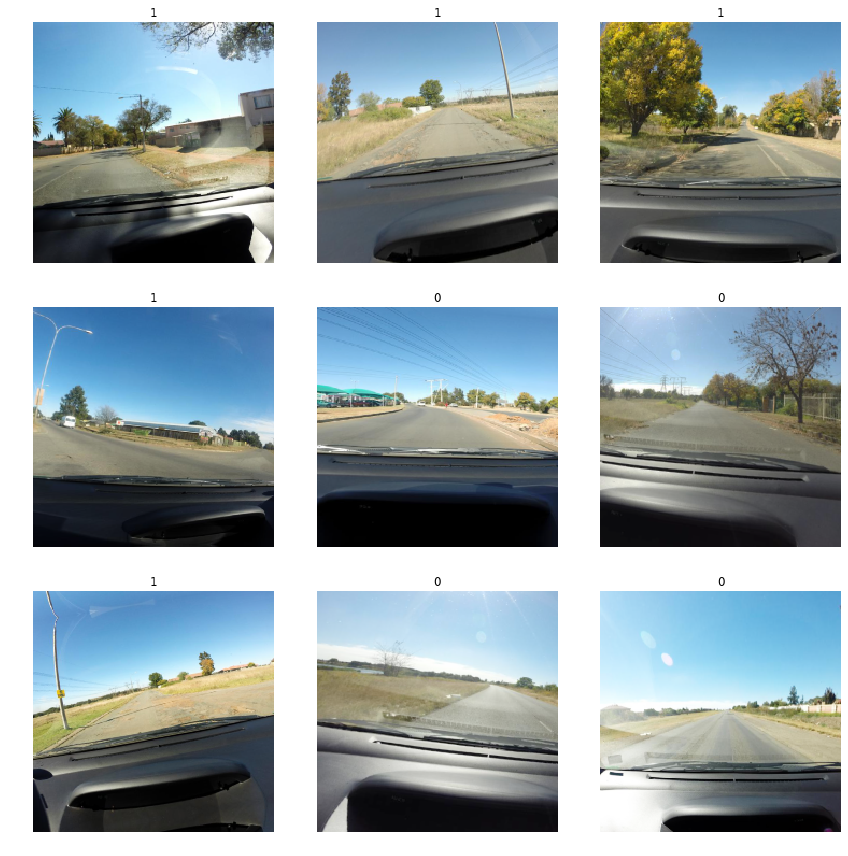

In [ ]:
data.show_batch(3)

### Model

The other major object that we need to define is the fastai `Learner`. This object contains everything we need to train the model, including: the databunch, model, loss function and optimiser. The following line of code does all of this:

In [ ]:
from fastai.vision.models import xresnet101
learn = cnn_learner(data, xresnet101, metrics=accuracy)

TypeError: ignored

We are telling it to use a ResNet18 and that we want to see the accuracy reported after every epoch. The other required information is derived from the data and/or set by default. For example, look at the chosen loss function and optimiser with the properies `learn.loss_func` and `learn.opt_func`, respectively.

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

There were also others things that were happening in the background when creating the learner. The weights of a ResNet18 trained on ImageNet were loaded, the head of the network was replaced with the appropriate size classification layer and all but the last layer was frozen (meaning that its weights won't be tuned during training).

### Train

Now we are almost ready to train the model. We are going to use the tried and test 1cycle training strategy, so all we need now is to determine a good learning rate. In fastai, we can do this like so:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


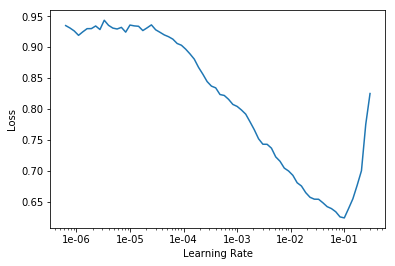

In [ ]:
learn.lr_find()
learn.recorder.plot()

From the figure, 1e-3 seems like a good choice. For more detail on this see the [docs](https://docs.fast.ai/callbacks.one_cycle.html).

In [ ]:
lr = 1e-2

Now we can start training. The first argument is the number of epoch we would like to run (remember, here we are only training the last layer, since all the others are frozen.)

In [ ]:
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.379332,2103.871582,0.432836,01:58
1,0.449139,420.991180,0.432836,01:59
2,0.509740,3717.105225,0.567164,01:58
3,0.609271,6.689472,0.424544,01:59
4,0.622468,0.726751,0.767828,02:00
5,0.589442,0.569249,0.729685,01:59
6,0.539904,0.563751,0.741294,02:00
7,0.494454,0.405952,0.822554,01:58
8,0.449968,0.386737,0.827529,01:59
9,0.430012,0.376933,0.819237,01:59


When we are happy with the state of the last layer, we can choose the train the other layers of the network. This might be tricky with this size dataset.

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


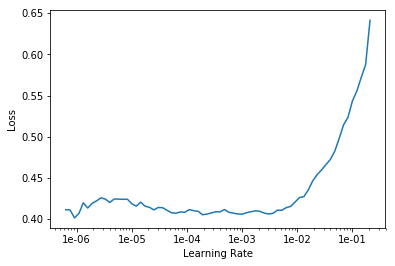

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-4

In [ ]:
lr

0.0001

When we pass a slice to the learning rate parameter, differential learning rates will be used. Meaning smaller learning rates will be used for the lower layers and the bigger learning rates for the upper layers.

In [ ]:
learn.fit_one_cycle(3, slice(lr/10,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.415380,0.391896,0.817579,01:57
1,0.412250,0.384406,0.819237,01:59
2,0.403580,0.377876,0.820895,01:59


To get predictions on the test set, run:

In [ ]:
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
preds[:, 1]

tensor([0.2226, 0.1309, 0.1182,  ..., 0.1958, 0.5370, 0.3383])

### Submission

In [ ]:
fnames = [o.split('/')[-1].split('.')[0] for o in learn.data.test_ds.items]

In [ ]:
import pandas as pd
subm = pd.DataFrame({'Image_ID': fnames, 'Label': preds[:, 1]})

In [ ]:
subm.to_csv('test.csv', index=None)

This can then be dragged and drop in the competition submission page.

## Where to improve

### Validation split

It is very important to get a validation set representative of the real world (in this case the test set). The test set are images taken at a different time than those in the training set. So they are likely to be very different in terms of the lighting (caused by the time of day and weather) and new scenes from the different roads. To make sure our models aren't overfitting to the training images, we will have to create a validation set in the same way, *i.e.* based on date and time. Look at the utilities for splitting data [here](https://docs.fast.ai/data_block.html#Step-2:-Split-the-data-between-the-training-and-the-validation-set).

### Data Augmentation

We have a relatively small dataset for image classification and from the training metrics in the basic version, it is quite apparent that we are very prone to overfitting on this data. One way to fight overfitting is to apply data augmentation during training. We used the defaut transforms in `get_transforms()` but there are many more to choose from. See [here](https://docs.fast.ai/vision.transform.html). Play around with these based on what makes sense for these images and see how it balances the training and validation losses. Pass your chosen transforms as a list to `ll.transform(tfms, ...)` as in the data section above.

A more modern data augmentation technique is [`mixup`](https://docs.fast.ai/callbacks.mixup.html). To apply mixup just append it to the learner object like this:

In [ ]:
learn = learn.mixup()

Other properties to play with are the image size and the resize method. Bigger images might help the model to find the smaller potholes but training will take longer and will be more prone to overfitting. The image size is also set in `ll.transform(..., size)`. We must be careful that the potholes aren't being cut off during data augmentation, one way to avoid this is to play with the [`resize_method`](https://docs.fast.ai/vision.image.html#ResizeMethod) also defined in `ll.transform(..., resize_method)`.

You might have noticed that roughly the bottom third of almost all of the images are of the car's dashboard. Obviously, there won't be any potholes so if you can find a smart way of cutting these parts of the images before training, you will save some compute and narrow the model's search space. But be careful not to cut off the important parts in the test images.

If you are bold, try running a segmentation model trained on the camvid dataset to pick out the roads. See [here](https://docs.fast.ai/tutorial.data.html#A-segmentation-example) for a fastai example.

### Models

We have used a small but reliable CNN for image classification, the ResNet18. But you can try any of the base architectures in `fastai.vision.models`. The larger architectures will be harder to train but might have more prediction power. You can also use custom architectures and/or train from scratch. Then the process to create a `Learner` would be:

```
model = # Define pytorch model here

learn = Learner(data, model, ...)
```

An approach that is almost guarranteed to work is ensembling. Ensembling in its simplest form is training multiple models (with different sizes, architectures, or even different models) and averaging its predictions on the test images to get a final prediction.

If you want to adjust the default dropout rate when using `cnn_learner`, set the values for the `ps` parameter: `cnn_learner(..., ps=dropout_value)`.

Sometimes the best performing model is not the one at the last epoch. To save the best model during training, use this fastai callback:

In [ ]:
learn.fit_one_cycle(3,1e-4, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

In [ ]:
learn.load('name.pth')

### Training

Try the biggest batch size that will fit into memory.

Recently the *RAdam* optimiser have been getting a lot of successes. Try these implementations:
- https://github.com/LiyuanLucasLiu/RAdam
- https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer?source=post_page-----2dc83f79a48d----------------------

to get more stable training runs, less sensitve to the chosen learning rate. Set the optimiser at:

In [ ]:
from ranger import RAdam

In [ ]:
learn = cnn_learner(..., opt_func=RAdam)

### Predictions

Use test time augmentation to get predictions on different versions of the test images and average them to get a final predictions. In fastai, you can do this with:

In [ ]:
preds, y = learn.TTA(ds_type=DatasetType.Test)

Look at the versions of the images created by TTA, because it might make images with no potholes in them which will thus hurt the accuracy.

### Inspect your results and look for clues

Fastai has built in interpretation methods for classification. See the following:

In [ ]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

You can look at the images that had the most wrong predictions:

In [ ]:
preds.shape

In [ ]:
y

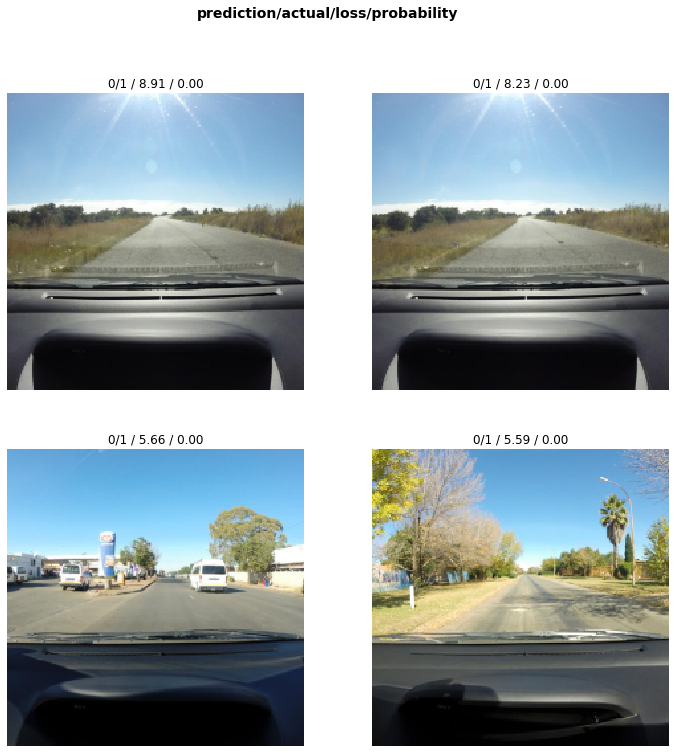

In [ ]:
interp.plot_top_losses(4)

Can you see a pattern here? What can you change to avoid these mistakes?